In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout, Dense, LSTM,Embedding
from tensorflow.keras.layers import LSTM,GRU
from joblib import dump, load
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from preprocessing import TimeSeriesPreprocessor



%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

In [2]:
# hyper params
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

SEQ_LEN = 14
PRED_LEN = 1

BATCH_SIZE = 16
DROPOUT = 0.2
model_path = os.path.join(os.getcwd(), 'model')
data_path = os.path.join(os.getcwd(), 'data')
result_path = os.path.join(os.getcwd(), 'result')

try:
    os.makedirs(model_path)
    os.makedirs(result_path)    

except FileExistsError:
    pass

### Data Preprocess

- 결측치 - 전일 값으로 대체

In [3]:
# 국제
dataset1 = pd.read_csv(os.path.join(data_path, "국제_원유가격.csv"), parse_dates=['기간'], encoding='utf-8')
dataset1 = dataset1.sort_values('기간')

# 국내
dataset2 = pd.read_csv(os.path.join(data_path, "주유소_평균판매가격.csv"), parse_dates=['구분'], encoding='utf-8')
dataset2 = dataset2.sort_values('구분')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


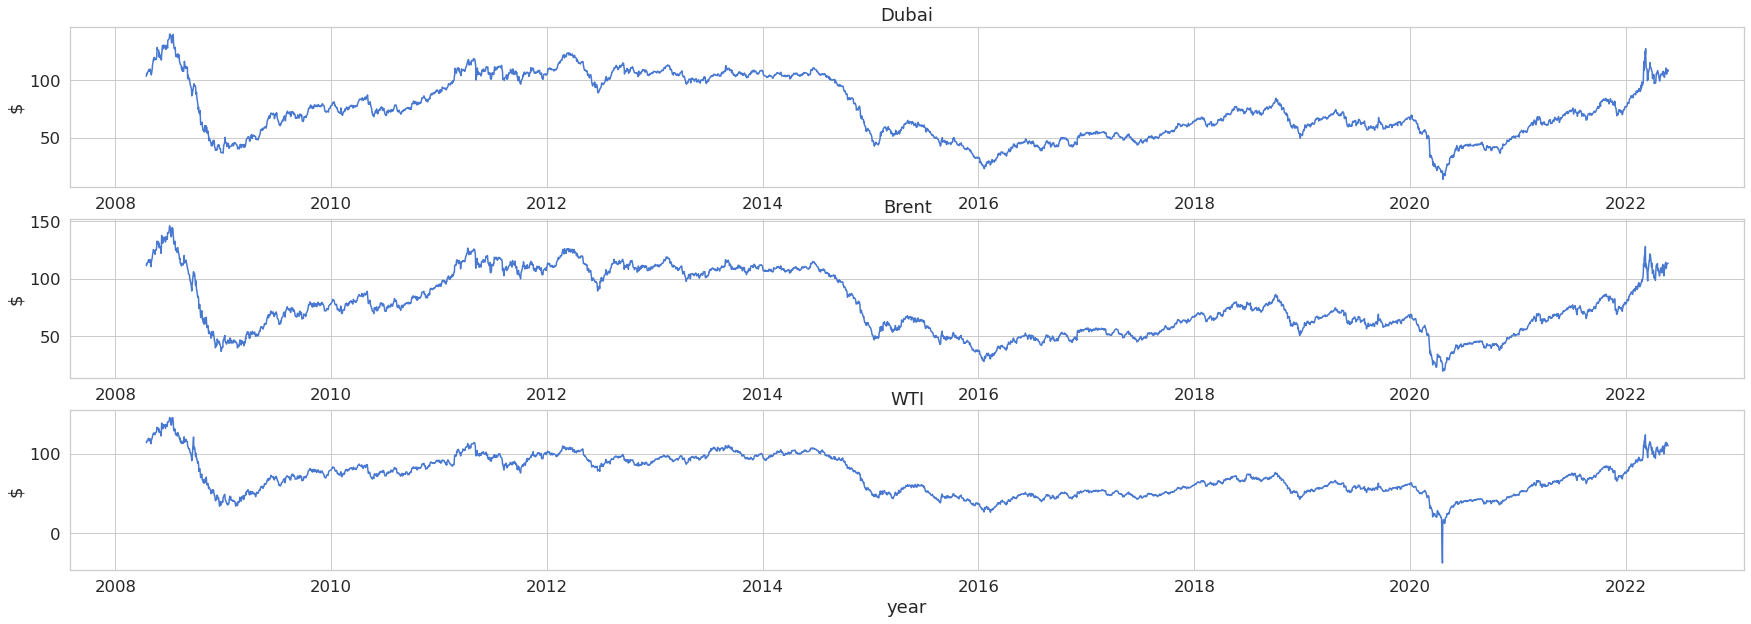

In [4]:
# 국제
plt.figure(figsize=(30, 10))
for i, c in enumerate(dataset1.columns[1:]):
    plt.subplot(3, 1, i+1)
    plt.plot(dataset1.iloc[:, 0], dataset1.iloc[:, i+1], label = c)
    plt.title(c)
    plt.xlabel('year')
    plt.ylabel('$')
plt.show()

/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 55064 (\N{HANGUL SYLLABLE HWI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from current font.
  fig.ca

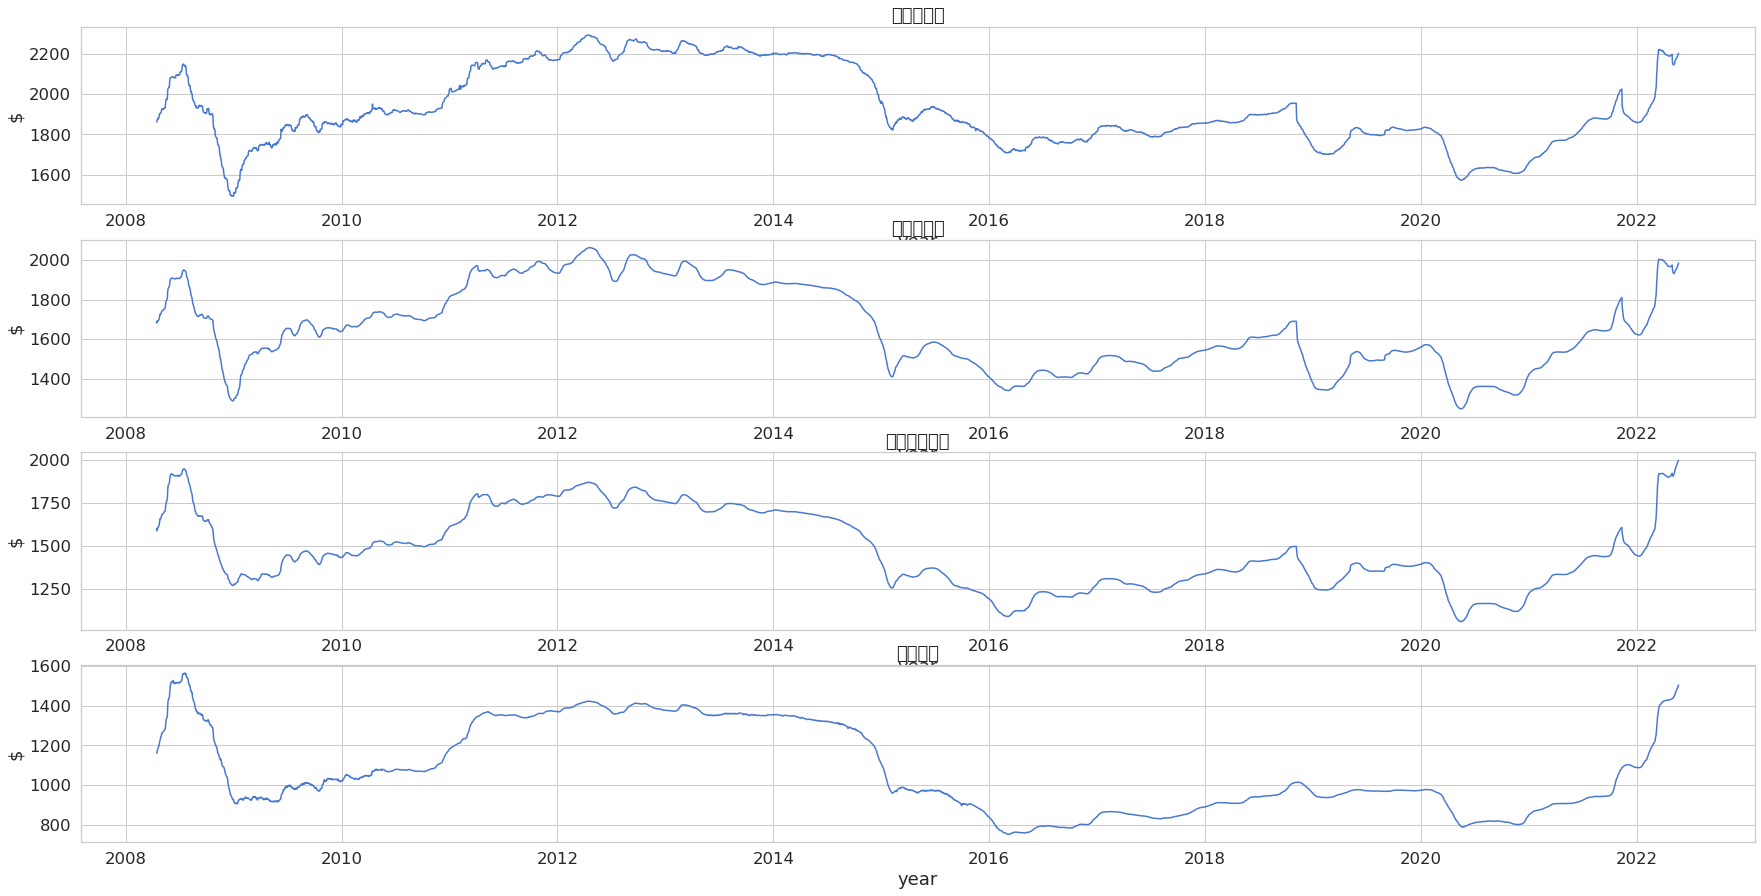

In [5]:
# 국내
plt.figure(figsize=(30, 15))
for i, c in enumerate(dataset2.columns[1:]):
    plt.subplot(4, 1, i+1)
    plt.plot(dataset2.iloc[:, 0], dataset2.iloc[:, i+1], label = c)
    plt.title(c)
    plt.xlabel('year')
    plt.ylabel('$')
plt.show()

In [6]:
total_dataset = pd.merge(left=dataset1, right=dataset2, left_on='기간', right_on='구분')
del total_dataset['구분']
total_dataset

,기간,Dubai,Brent,WTI,고급휘발유,보통휘발유,자동차용경유,실내등유
0,2008-04-15,103.66,111.31,113.79,1861.80,1681.33,1585.35,1159.41
1,2008-04-16,105.16,112.66,114.93,1871.39,1692.15,1600.81,1168.47
2,2008-04-17,106.39,112.43,114.86,1874.54,1686.56,1594.53,1174.24
3,2008-04-18,105.83,113.92,116.69,1877.81,1689.68,1602.15,1179.31
4,2008-04-21,107.96,114.43,117.48,1881.82,1695.54,1610.82,1191.62
...,...,...,...,...,...,...,...,...
3637,2022-05-16,106.65,114.24,114.20,2177.84,1958.73,1970.51,1481.83
3638,2022-05-17,110.88,111.93,112.40,2183.42,1963.26,1976.49,1485.38
3639,2022-05-18,109.79,109.11,109.59,2185.95,1967.33,1981.61,1489.18
3640,2022-05-19,105.52,112.04,112.21,2191.74,1972.11,1986.76,1493.57


In [7]:
total_dataset.corr() # Brent price - 가장 큰 관련

,Dubai,Brent,WTI,고급휘발유,보통휘발유,자동차용경유,실내등유
Dubai,1.000000,0.996780,0.973240,0.892202,0.939587,0.958057,0.929514
Brent,0.996780,1.000000,0.975489,0.895856,0.940608,0.958887,0.932900
WTI,0.973240,0.975489,1.000000,0.837694,0.902133,0.930084,0.900427
고급휘발유,0.892202,0.895856,0.837694,1.000000,0.959203,0.923680,0.909001
보통휘발유,0.939587,0.940608,0.902133,0.959203,1.000000,0.977514,0.939155
자동차용경유,0.958057,0.958887,0.930084,0.923680,0.977514,1.000000,0.972848
실내등유,0.929514,0.932900,0.900427,0.909001,0.939155,0.972848,1.000000


brent oil 설명: https://bibeom.com/2020/03/08/%EA%B5%AD%EC%A0%9C%EC%9C%A0%EA%B0%80%EC%97%90-%ED%88%AC%EC%9E%90%ED%95%98%EB%8A%94-3%EA%B0%80%EC%A7%80-%EB%B0%A9%EB%B2%95%EB%B8%8C%EB%A0%8C%ED%8A%B8%EC%9C%A0-wti%ED%85%8D%EC%82%AC%EC%8A%A4%EC%9C%A0/

#

In [8]:
df1 = total_dataset.loc[:,['Brent', '고급휘발유']]

In [9]:
df1

,Brent,고급휘발유
0,111.31,1861.80
1,112.66,1871.39
2,112.43,1874.54
3,113.92,1877.81
4,114.43,1881.82
...,...,...
3637,114.24,2177.84
3638,111.93,2183.42
3639,109.11,2185.95
3640,112.04,2191.74


In [10]:
# scaling data
scaler1 = MinMaxScaler()
scaled_df1 = scaler1.fit_transform(df1)

In [11]:
def to_sequences(data, seq_len, pred_len):
    x_train = []
    y_train = []

    for i in range(seq_len, len(data) - pred_len + 1):
        x_train.append(data[i - seq_len: i, 0])
        y_train.append(data[i + pred_len - 1: i + pred_len, 1])

    return np.array(x_train), np.array(y_train)

def preprocess(data_raw, seq_len, pred_len, train_split):

    x_data, y_data = to_sequences(data_raw, seq_len, pred_len)
    num_train = int(train_split * x_data.shape[0])

    X_train = x_data[:num_train, :]
    y_train = y_data[:num_train, :]

    X_test = x_data[num_train:, :]
    y_test = y_data[num_train:, :]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_df1, SEQ_LEN, PRED_LEN, train_split = 0.95)
print("train data shape: ",[X_train.shape, y_train.shape])
print("test data shape: ", [X_test.shape, y_test.shape])

train data shape:  [(3446, 14), (3446, 1)]
test data shape:  [(182, 14), (182, 1)]


In [12]:
X_train

array([[0.72568047, 0.73633136, 0.73451677, ..., 0.72607495, 0.71928994,
        0.7513215 ],
       [0.73633136, 0.73451677, 0.74627219, ..., 0.71928994, 0.7513215 ,
        0.77838264],
       [0.73451677, 0.74627219, 0.75029586, ..., 0.7513215 , 0.77838264,
        0.79668639],
       ...,
       [0.39589744, 0.39211045, 0.38579882, ..., 0.42335306, 0.41230769,
        0.42366864],
       [0.39211045, 0.38579882, 0.37175542, ..., 0.41230769, 0.42366864,
        0.42035503],
       [0.38579882, 0.37175542, 0.3617357 , ..., 0.42366864, 0.42035503,
        0.41727811]])

In [13]:
def train_model(X_train, y_train, BATCH_SIZE):
    model = keras.Sequential()

    #################################
    model.add(GRU(64,return_sequences=True,input_shape=(X_train.shape[1],1)))
   
    model.add(GRU(32,return_sequences=True))
    model.add(Dropout(rate=DROPOUT))
    
    model.add(GRU(16,return_sequences=False))
    
    model.add(Dense(y_train.shape[1]))

    model.compile(
        loss='mean_squared_error',
        optimizer='adam'
    )
    ################################
    
    model.summary()
    
    history = model.fit(
        X_train, 
        y_train, 
        epochs=50, 
        batch_size=BATCH_SIZE, 
        shuffle=False,
        validation_split=0.1
    )

    return model, history

model, history = train_model(X_train, y_train, BATCH_SIZE)

2022-06-03 21:38:33.080414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-03 21:38:33.080622: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14, 64)            12864     
                                                                 
 gru_1 (GRU)                 (None, 14, 32)            9408      
                                                                 
 dropout (Dropout)           (None, 14, 32)            0         
                                                                 
 gru_2 (GRU)                 (None, 16)                2400      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 24,689
Trainable params: 24,689
Non-trainable params: 0
____________________________________

2022-06-03 21:38:33.390284: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-03 21:38:34.439690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-03 21:38:34.766940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-03 21:38:35.391133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-03 21:38:35.735952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-03 21:38:36.603373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-03 21:38:37.826377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112

194/194 [==============================] - ETA: 0s - loss: 0.0142

2022-06-03 21:38:43.691856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-03 21:38:43.790972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-03 21:38:43.825259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-03 21:38:43.861768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


194/194 [==============================] - 11s 31ms/step - loss: 0.0142 - val_loss: 0.0253
Epoch 2/50
194/194 [==============================] - 4s 21ms/step - loss: 0.0063 - val_loss: 0.0185
Epoch 3/50
194/194 [==============================] - 4s 21ms/step - loss: 0.0062 - val_loss: 0.0164
Epoch 4/50
194/194 [==============================] - 4s 21ms/step - loss: 0.0057 - val_loss: 0.0152
Epoch 5/50
194/194 [==============================] - 4s 21ms/step - loss: 0.0053 - val_loss: 0.0143
Epoch 6/50
194/194 [==============================] - 4s 21ms/step - loss: 0.0050 - val_loss: 0.0136
Epoch 7/50
194/194 [==============================] - 4s 21ms/step - loss: 0.0048 - val_loss: 0.0130
Epoch 8/50
194/194 [==============================] - 4s 21ms/step - loss: 0.0047 - val_loss: 0.0126
Epoch 9/50
194/194 [==============================] - 4s 21ms/step - loss: 0.0045 - val_loss: 0.0122
Epoch 10/50
194/194 [==============================] - 4s 21ms/step - loss: 0.0045 - val_loss: 0.0120

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14, 64)            12864     
                                                                 
 gru_1 (GRU)                 (None, 14, 32)            9408      
                                                                 
 dropout (Dropout)           (None, 14, 32)            0         
                                                                 
 gru_2 (GRU)                 (None, 16)                2400      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 24,689
Trainable params: 24,689
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 41ms/step - loss: 0.0189


0.01887441985309124

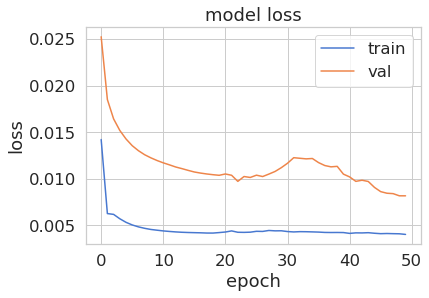

In [16]:
# Convergence of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

2022-06-03 21:45:22.047642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-03 21:45:22.138057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-03 21:45:22.175413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-03 21:45:22.217600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.ca

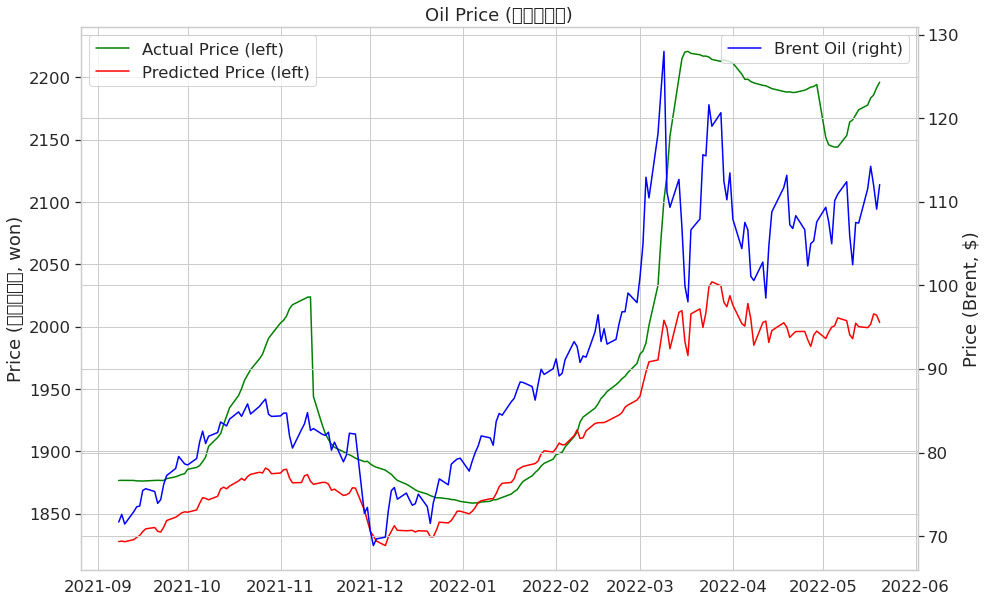

In [17]:
# Prediction
def draw_plot_test(model, df, X_test, y_test, scaler):
    y_hat = model.predict(X_test)

    y_test_ = [y[0] for y in y_test]
    y_hat = [y[0] for y in y_hat]

    y_test_inverse = scaler.inverse_transform(pd.DataFrame(
        {df.columns[0]: X_test[:,-1], 
        df.columns[1]: y_test_}
        ))
    y_hat_inverse = scaler.inverse_transform(pd.DataFrame(
        {df.columns[0]: X_test[:,-1], 
        df.columns[1]: y_hat}
        ))

    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax1.plot(total_dataset.iloc[-len(X_test):, 0], y_test_inverse[:, 1], label="Actual Price (left)", color='green')
    ax1.plot(total_dataset.iloc[-len(X_test):, 0], y_hat_inverse[:, 1], label="Predicted Price (left)", color='red')
    ax1.set_ylabel(f'Price ({df.columns[1]}, won)')

    ax2 = ax1.twinx()
    ax2.plot(total_dataset.iloc[-len(X_test):, 0], y_test_inverse[:, 0], label="Brent Oil (right)", color='blue')
    ax2.set_ylabel(f'Price (Brent, $)')

    plt.title(f'Oil Price ({df.columns[1]})')
    plt.xlabel('Time [days]')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()
    
draw_plot_test(model, df1, X_test, y_test, scaler1)

/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 55064 (\N{HANGUL SYLLABLE HWI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/seungyoo/miniforge3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from current font.
  fig.ca

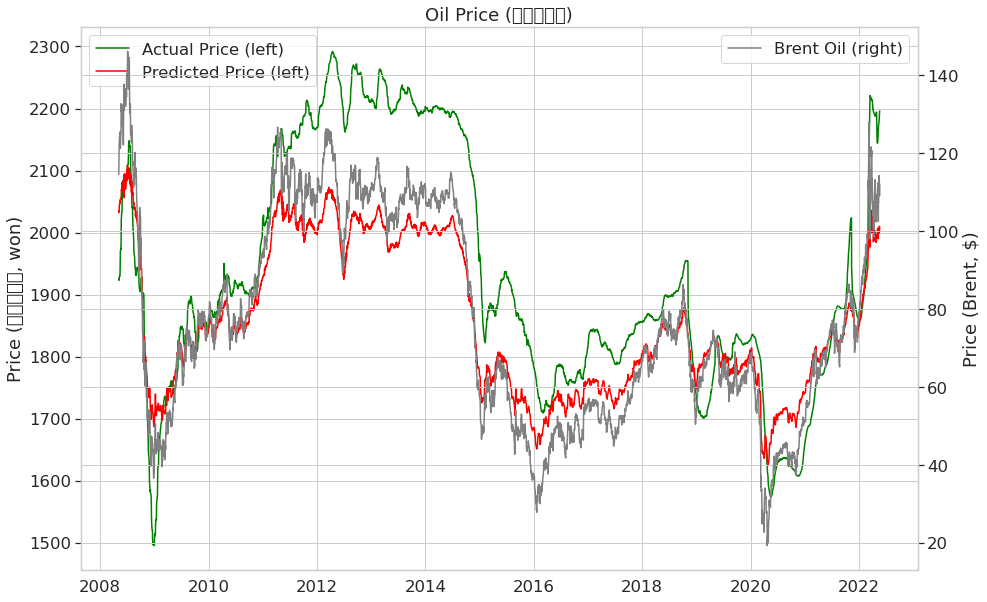

In [18]:
def draw_plot_total(model, df, X_total, y_total, scaler):
    y_total_hat = model.predict(X_total)

    y_total_ = [y[0] for y in y_total]
    y_total_hat = [y[0] for y in y_total_hat]

    y_test_inverse = scaler.inverse_transform(pd.DataFrame(
        {df.columns[0]: X_total[:,-1], 
        df.columns[1]: y_total_}
        ))
    y_hat_inverse = scaler.inverse_transform(pd.DataFrame(
        {df.columns[0]: X_total[:,-1], 
        df.columns[1]: y_total_hat}
        ))

    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax1.plot(total_dataset.iloc[-len(X_total):, 0], y_test_inverse[:, 1], label="Actual Price (left)", color='green')
    ax1.plot(total_dataset.iloc[-len(X_total):, 0], y_hat_inverse[:, 1], label="Predicted Price (left)", color='red')
    ax1.set_ylabel(f'Price ({df.columns[1]}, won)')

    ax2 = ax1.twinx()
    ax2.plot(total_dataset.iloc[-len(X_total):, 0], y_test_inverse[:, 0], label="Brent Oil (right)", color='grey')
    ax2.set_ylabel(f'Price (Brent, $)')

    plt.title(f'Oil Price ({df.columns[1]})')
    plt.xlabel('Time [days]')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()

X_total = np.concatenate([X_train, X_test])
y_total = np.concatenate([y_train, y_test])
draw_plot_total(model, df1, X_total, y_total, scaler1)

In [29]:
def mae(actual,predict):
    return np.mean(abs(actual-predict))

def RMSE(actual,predict):
    return np.sqrt(np.mean((actual-predict)**2))


In [30]:
mae(y_test,model.evaluate(X_test,y_test))

6/6 [==============================] - 0s 10ms/step - loss: 0.0189


0.6026878572810663

In [31]:
RMSE(y_test,model.evaluate(X_test,y_test))

6/6 [==============================] - 0s 10ms/step - loss: 0.0189


0.6251394595091853